# TLS Experiments of UA Q2

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qm.octave import QmOctaveConfig
from quam import QuAM

from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
#from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber
import xarray as xr

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 0 # for UA Q2
TLS_index = 1 # for TLS of interest
dc_flux_index = 1 # for dc line

2024-05-20 20:40:58,081 - qm - INFO     - Starting session: 00b3e45f-63c1-4de1-a727-45f0ce9f0db2


In [2]:
Analysis = AnalysisHandle("quam_state_q1.json")
machine = Analysis.get_machine()
Experiment = ExperimentHandle(machine)

In [ ]:
# initialize Labber-controlled hardware
# get values from QDAC first
#machine = Experiment.set_Labber.get_value_from_QDAC(machine)
# set all Labber settings
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
# set octave to external clock
Experiment.set_octave.set_clock(machine)

In [ ]:
# set for the qubit
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

# TLS Characterizations

In [ ]:
TLS_index = 1

## TLS T1 (swap)

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(20,3000E3+1,100E3)
machine, expt_dataset = Experiment.exp1D.T1.TLS_T1(machine, tau_sweep_abs, qubit_index, TLS_index,
                   n_avg = 500, cd_time_qubit = 25E3, cd_time_TLS = 500E3, live_plot = True, data_process_method = 'I')

In [ ]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(expt_dataset, data_process_method = 'I')

# TLS Driving Pulses

## TLS spectroscopy

In [ ]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index] + np.arange(-15E6,15E6+1,0.3E6)
machine, expt_dataset = Experiment.exp1D.Rabi.TLS_freq(machine, TLS_freq_sweep, qubit_index, TLS_index,
                  n_avg = 1E3, cd_time_qubit = 25E3, cd_time_TLS = 500E3, live_plot = True)

In [ ]:
%matplotlib inline
TLS_freq = Analysis.exp1D.peak_fit(expt_dataset, method = "Gaussian", data_process_method = 'I')
machine.qubits[qubit_index].f_tls[TLS_index] = TLS_freq + 0E6
machine = Analysis.set_machine(machine)

## TLS rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(16, 8000 + 0.1, 80)  # in units of clock cyles
machine, expt_dataset = Experiment.exp1D.Rabi.TLS_rabi_length(machine, rabi_duration_sweep, qubit_index, TLS_index,
                      n_avg = 1E3, cd_time_qubit = 25E3, cd_time_TLS = 500E3, live_plot = True)

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(expt_dataset, method = "Decay", to_plot = True, data_process_method = 'I')

In [ ]:
machine.qubits[qubit_index].pi_amp_tls[TLS_index] = 0.4677
machine.qubits[qubit_index].pi_length_tls[TLS_index] = 340
machine = Analysis.set_machine(machine)

## TLS Ramsey

In [ ]:
%matplotlib qt
ramsey_duration_sweep = np.arange(16, 1800 + 0.1, 28)  # in units of ns
machine, expt_dataset = Experiment.exp1D.Ramsey.TLS_ramsey(machine, ramsey_duration_sweep, qubit_index, TLS_index,
                       n_avg = 1000, detuning = 5E6, cd_time_qubit = 25E3, cd_time_TLS = 500E3, live_plot = True)

In [ ]:
%matplotlib inline
tls_T2star = Analysis.exp1D.ramsey(expt_dataset, data_process_method = 'I')

As a sanity check, run fft, see if there are multiple peaks

In [ ]:
fft_dataset = Analysis.exp1D.fft(expt_dataset, data_process_method = 'I')

## TLS T1 with direct driving

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(1E3,2500E3+1,100E3)
machine, expt_dataset = Experiment.exp1D.T1.TLS_T1_drive(machine, tau_sweep_abs, qubit_index, TLS_index,
                     n_avg = 1E3, cd_time_qubit = 25E3, cd_time_TLS = 2000E3, live_plot = True)

In [ ]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(expt_dataset, data_process_method = 'I')

# TLS Dynamical Decoupling

## TLS echo

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(500, 120E3 + 0.1, 2E3)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_echo(machine, tau_sweep_abs, qubit_index, TLS_index, n_avg = 1E3,
                     cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = True)

In [ ]:
%matplotlib inline
TLS_T2echo = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I')

## TLS CPMG-2

In [ ]:
%matplotlib qt
N_CPMG = 2
tau_sweep_abs = np.arange(500, 80E3 + 0.1, 2E3)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 1E3, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = True)

Qubit T2*:  60.7 [us]
Exponent n =  1.1


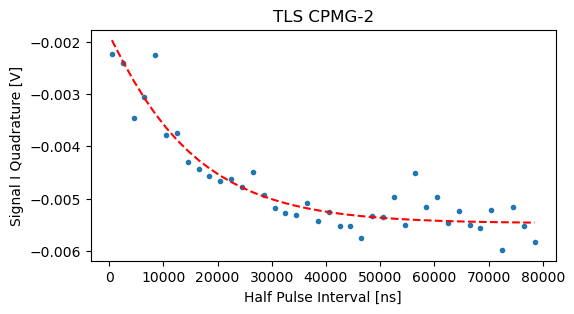

In [9]:
%matplotlib inline
TLS_T2dd = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau = 2 * N_CPMG)

## TLS CPMG-8

In [11]:
%matplotlib qt
N_CPMG = 8
tau_sweep_abs = np.arange(500, 30E3 + 0.1, 1.5E3)  # in units of ns
machine, expt_dataset = Experiment.exp1D.DD.TLS_CPMG(machine, tau_sweep_abs, qubit_index, TLS_index, N_CPMG = N_CPMG,
                     n_avg = 1E3, cd_time_qubit = 25E3, cd_time_TLS = 1500E3, live_plot = True)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 35.30s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 35.34s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0520\2024-05-20_q1t1_tls_cpmg8_2
Execution stopped by user!


Qubit T2*:  124.5 [us]
Exponent n =  2.3


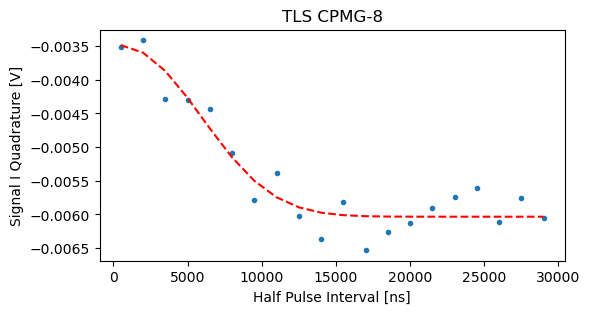

In [13]:
%matplotlib inline
TLS_T2dd = Analysis.exp1D.T2(expt_dataset, data_process_method = 'I', N_tau = 2 * N_CPMG)